# Building Autonomous Systems

We will discuss a variety of approaches to building autonomous systems.

Reading: DMU 1.1-1.3

# Decision Making

Decision making is the process of deciding what to do.

An _agent_ takes _actions_ in an environment. Decision making requires choosing the actions.

$$\text{action} = act(\> \text{agent}, \text{state}\>)$$

Oftentimes the agent has to make decisions with incomplete information.

$$\text{action} = act(\> \text{agent}, \text{state}, \text{belief}\>)$$

An _intelligent_ agent interacts with the world such that it achieves its objectives over time.

![Interaction between the environment and the agent.](figures/agent_environment_interaction.png)

## Traffic Alert and Collision Avoidance System

TCAS is an onboard collision avoidance system for all medium - large aircraft. The system provides resolution advisories to pilots, instructing them to adjust their climb or descent rate to avoid collision.

![](figures/pic_tcas_001.jpg)

TCAS is the final line of defense before a collision. Many safety systems and protocols must fail before it comes into effect.

![](figures/protected-area.jpg)

TCAS looks at the approach rate and decides whether to have the airplane pull up or down. A simplified implementation is given in `AA120Q.jl`.

In [1]:
using AA120Q, TikzPictures
agent = TCAS()

TCAS(Advisory(NaN), 22.5)

The TCAS agent is a `FullyObservableCollisionAvoidanceSystem`, meaning it assumes perfect state information.

```
TCAS <: FullyObservableCollisionAvoidanceSystem
```

It implements two functions: `reset!` and `update!`

In [2]:
# reset the TCAS agent to its initial state
function reset!(tcas::TCAS)
    tcas.advisory = ADVISORY_NONE
    tcas
end

reset! (generic function with 1 method)

In [3]:
# update! contains the real logic
function update!(tcas::TCAS, s1::AircraftState, s2::AircraftState, params::EncounterSimParams)
    # ... collision avoidance logic ... #
    tcas.advisory
end

update! (generic function with 1 method)

Note that TCAS is completely deterministic.

The next-gen collision avoidance system, ACAS-X, was developed with stochasticity in mind.

![](figures/decision_theoretic_planning.png)

In this class you will build your own collision avoidance system for aircraft.

# Decision Making Processes

Computational models of learning have proved largely successful in characterizing potential mechanisms which allow the making of decisions in uncertain and volatile contexts. We can adapt a learning model, depending on separate parameters according to whether we provide a reward or a punishment, can be applied to decision making under uncertainty.

An agent-based decision making model is one of a class of computational models for simulating the actions and interactions of autonomous agents with a view to assessing their effects on the system as a whole. Monte Carlo methods are used to introduce randomness. A central tenet is that the whole is greater than the sum of the parts. Individual agents are typically characterized as boundedly rational, presumed to be acting in what they perceive as their own interests, using heuristics or simple decision-making rules.

# The Grid World Process

In the grid world problem we have a $10 \times 10$ grid. Each cell in the grid represents a state in an MDP. The available actions are up, down, left, and right. The effects of these actions are stochastic. We move one step in the specified direction with probability 0.7, and we move one step in one of the three other directions, each with probability 0.1. If we bump against the outer border of the grid, we do not move at all.

We receive a cost of 1 for bumping against the outer border of the grid. There are four cells in which we receive rewards upon entering:
* $(8,9)$ has a reward of $+10$
* $(3,8)$ has a reward of $+3$
* $(5,4)$ has a reward of $-5$
* $(8,4)$ has a reward of $-10$

In [4]:
using Interact
include("gridworld.jl")

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/790a2899848cb55930c57eec87df6d5182e9094b-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/790a2899848cb55930c57eec87df6d5182e9094b-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

plot (generic function with 6 methods)

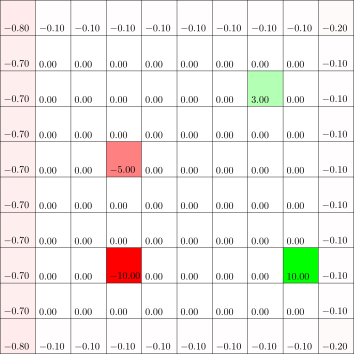

┌ Warning: tikzpicture.svg already exists, overwriting!
└ @ TikzPictures C:\Users\mykel\.julia\dev\TikzPictures\src\TikzPictures.jl:414


In [5]:
g = GridWorld()
plot(g)

The coordinates are specified using the matrix convention in which the first coordinate is the row starting from the top and the second coordinate is the column starting from the left. The cells with rewards of $+10$ and $+3$ are absorbing states where no additional reward is ever received from that point onward.

## Policy Evaluation

You can estimate the value of a state by successively propagating the reward from other states.

In [6]:
function iterativePolicyEvaluation(mdp::MDPs.MDP, policy::Function, numIterations::Integer)
    (S, A, T, R, discount) = MDPs.locals(mdp)
    U = zeros(Float64, length(S))
    for t = 1:numIterations
        U = [R(s0, policy(s0)) + discount*sum(s1->T(s0, policy(s0), s1)*U[s1], S) for s0 in S]
    end
    U
end;

In [7]:
@manipulate for numIterations in 0:10, a in MDPs.actions(g), discount in 0.1:0.1:0.9
    policy = s -> a
    g.discount = discount
    U = iterativePolicyEvaluation(g, policy, numIterations)
    plot(g, U, policy)
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:numIterations=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
5), Observable{Int64} with 2 listeners. Value:
5, Scope("knockout-component-a7a09488-cd37-4391-828d-448c32d0e0bf", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["numIterations"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>10,:min=>0,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
5, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\all.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\style.css", "C:\\Users\\mykel\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":5}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-a7a09488-cd37-4391-828d-448c32d0e0bf\",\"id\":\"ob_02\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (WebIO.setval({\"name\":\"value\",\"scope\":\"knockout-component-a7a09488-cd37-4391-828d-448c32d0e0bf\",\"id\":\"ob_01\",\"type\":\"observable\"},val)) : undefined; return this.

┌ Warning: tikzpicture.svg already exists, overwriting!
└ @ TikzPictures C:\Users\mykel\.julia\dev\TikzPictures\src\TikzPictures.jl:414


# Solving for the Optimal Policy

$U^*_k(s) = \max_a\left[R(s, a) + \gamma \sum_{s'} T(s' \mid s, a)U^*_{k+1}(s')\right]$  
$\pi^*(s) = \arg\max_a\left[R(s, a) + \gamma \sum_{s'} T(s' \mid s, a)U^*(s')\right]$  

In [8]:
function valueIteration(mdp::MDPs.MDP, numIterations::Integer; discount = 0.9)
    (S, A, T, R) = MDPs.locals(mdp)
    U = zeros(Float64, length(S))
    for t = 1:numIterations
        Q(s0, a) = R(s0, a) + discount*sum(s1 ->T(s0, a, s1)*U[s1], S)
        U = [maximum(a->Q(s0,a), A) for s0 in S]
    end
    U
end
function extractPolicy(mdp::MDPs.MDP, U::Vector)
    (S, A, T, R, discount) = MDPs.locals(mdp)    
    Q(s0, a) = R(s0, a) + discount*sum(s1->T(s0, a, s1)*U[s1], S)
    [A[argmax([Q(s0,a) for a in A])] for s0 in S]
end;

In [9]:
@manipulate for numIterations in 0:10, discount in 0.1:0.1:0.9
    U = valueIteration(g, numIterations, discount = discount)
    policy = extractPolicy(g, U)
    plot(g, U, policy)
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:numIterations=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
5), Observable{Int64} with 2 listeners. Value:
5, Scope("knockout-component-b7407840-2421-495a-8e57-42ea7a0e0915", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["numIterations"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>10,:min=>0,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
5, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\all.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\style.css", "C:\\Users\\mykel\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":5}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-b7407840-2421-495a-8e57-42ea7a0e0915\",\"id\":\"ob_17\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (WebIO.setval({\"name\":\"value\",\"scope\":\"knockout-component-b7407840-2421-495a-8e57-42ea7a0e0915\",\"id\":\"ob_16\",\"type\":\"observable\"},val)) : undefined; return this.

┌ Warning: tikzpicture.svg already exists, overwriting!
└ @ TikzPictures C:\Users\mykel\.julia\dev\TikzPictures\src\TikzPictures.jl:414


## Policy Evaluation in Continuous Spaces

For continuous spaces you often cannot use discrete solving methods.
Instead, if you have a policy $\pi(s) \rightarrow a$ and a distribution over the initial state, you can evaluate it by running a lot of simulations and returning the mean reward.

### Moutain Car

An [under-powered car must drive up a steep hill](https://en.wikipedia.org/wiki/Mountain_Car). Simply holding the throttle isn't good enough.

__State__: position $x$ and velocity $v$

In [10]:
mutable struct MountainCar
    x::Float64 # position
    v::Float64 # speed
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:x=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
16,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["-1.5", "-1.4", "-1.3", "-1.2", "-1.1", "-1.0", "-0.9", "-0.8", "-0.7", "-0.6"  …  "0.6", "0.7", "0.8", "0.9", "1.0", "1.1", "1.2", "1.3", "1.4", "1.5"],:formatted_value=>Observable{String} with 1 listeners. Value:
"0.0",:value=>Observable{Float64} with 2 listeners. Value:
0.0), Observable{Float64} with 2 listeners. Value:
0.0, Scope("knockout-component-0b1847bd-ce96-41c8-a625-aeace951d676", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["x"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>31,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["-1.5", "-1.4", "-1.3", "-1.2", "-1.1", "-1.0", "-0.9", "-0.8", "-0.7", "-0.6"  …  "0.6", "0.7", "0.8", "0.9", "1.0", "1.1", "1.2", "1.3", "1.4", "1.5"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"0.0", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
16, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\all.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\style.css", "C:\\Users\\mykel\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"formatted_vals\\\":[\\\
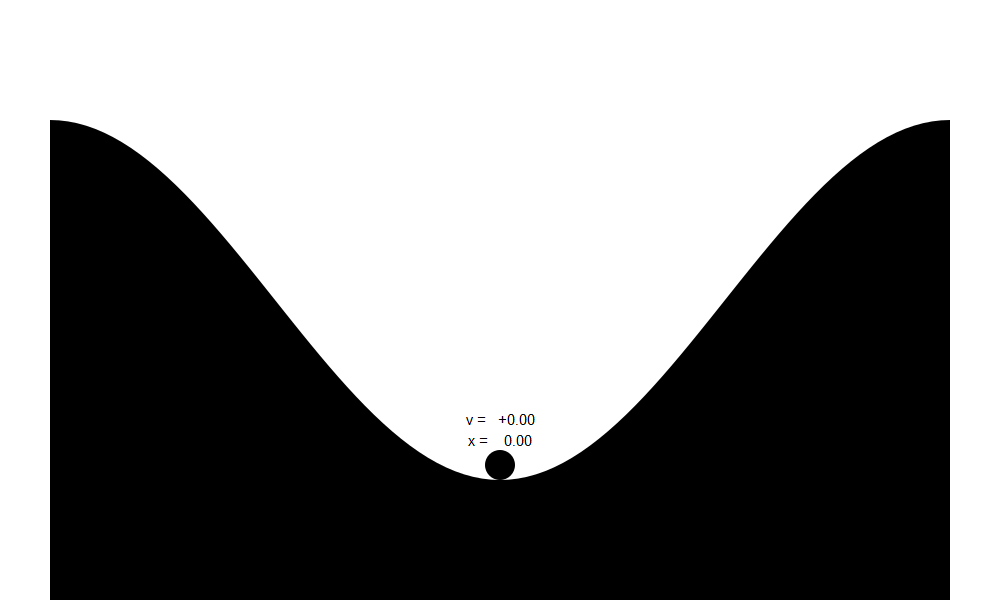
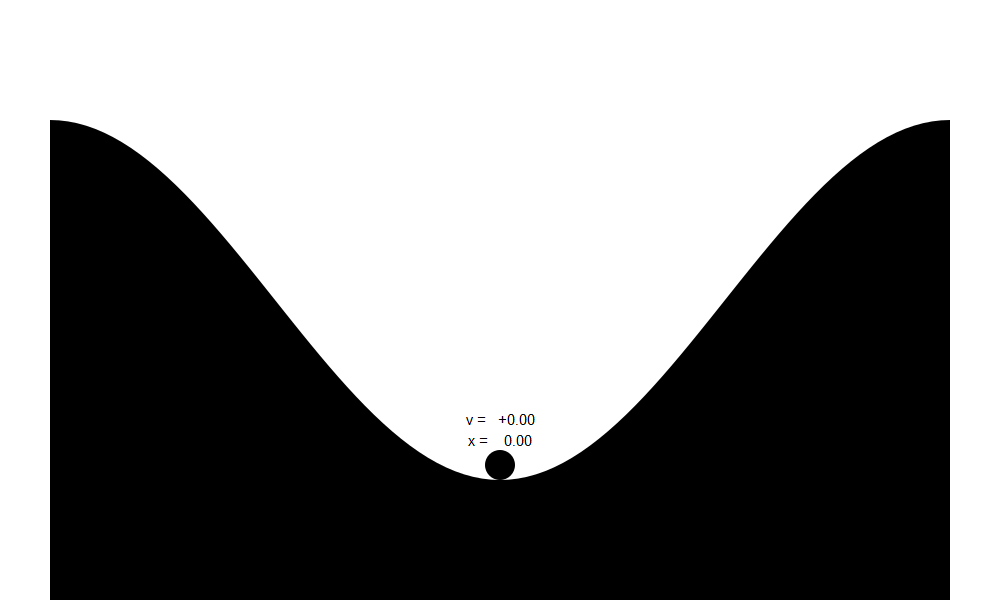

In [11]:
include("mountaincar.jl")
@manipulate for x in -1.5:0.1:1.5, y in -1.0:0.25:1.0
    render_mountain_car(MountainCar(x,y), render_pos_overlay=true)
end

__Actions__: accelerate left, right or coast

In [12]:
function update!(car::MountainCar, a::Symbol)
    act = (a == :left ? -1 : (a == :right ? 1 : 0))
    v2 = car.v + act*0.001 - sin((car.x/1.5 + 1)*pi)*-0.0025
    x2 = clamp(car.x + v2, -1.5, 1.5)
    MountainCar(x2, v2)
end

update! (generic function with 2 methods)

__Reward__: $R(s,a) = y$

```julia
reward(car::MountainCar, a::Symbol) = -cos(car.x/1.5*pi)
```

### Policy: Floor It

┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose C:\Users\mykel\.julia\packages\Compose\wlPCt\src\Compose.jl:164


Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:i=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
100), Observable{Int64} with 2 listeners. Value:
100, Scope("knockout-component-ee64b839-6a16-48fb-83b3-95b6d8623ad4", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>200,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
100, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\all.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\style.css", "C:\\Users\\mykel\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":100}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-ee64b839-6a16-48fb-83b3-95b6d8623ad4\",\"id\":\"ob_40\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (WebIO.setval({\"name\":\"value\",\"scope\":\"knockout-component-ee64b839-6a16-48fb-83b3-95b6d8623ad4\",\"id\":\"ob_39\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[
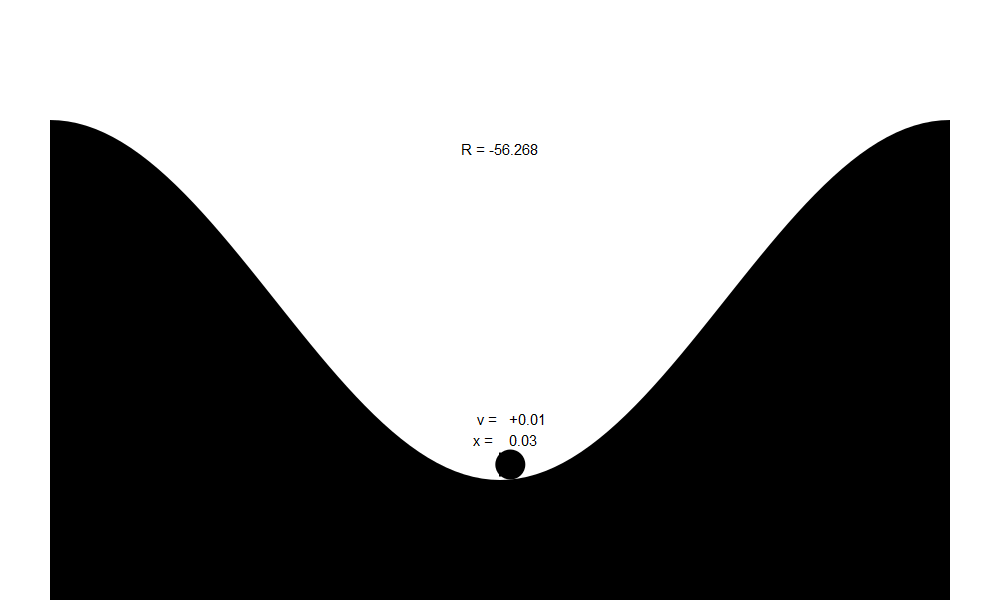
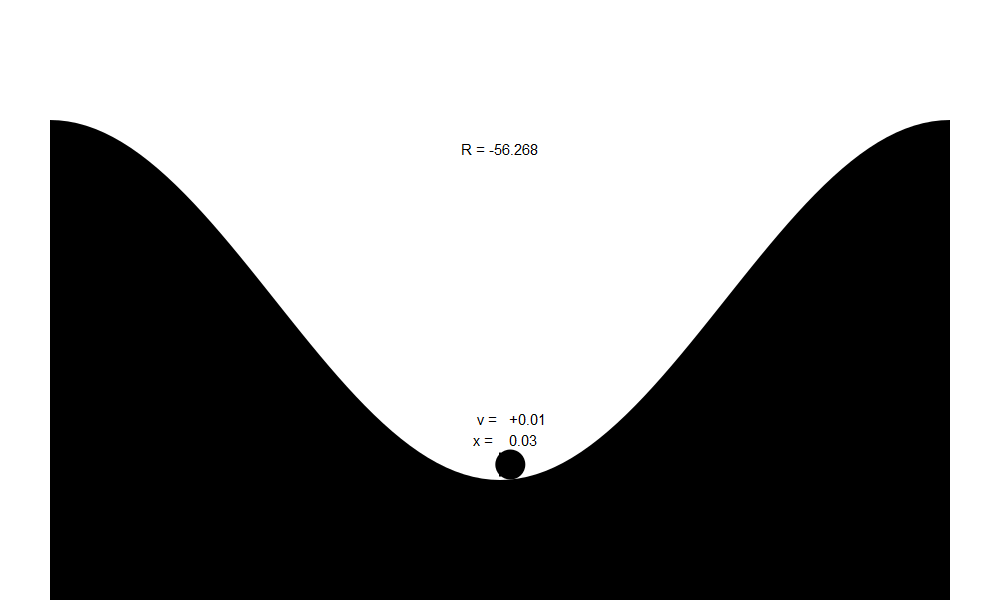

In [13]:
using Compose
function animate(steps)
    car = MountainCar(0.0,0.0)
    frames = []
    R = 0
    for t = 1:steps
        a = :right
        car = update!(car, a)
        R = R*0.99 + reward(car, a)
        push!(frames, render_mountain_car(car, render_pos_overlay=true, reward=R))
    end
    frames
end

animation = animate(200)
@manipulate for i = 1:length(animation)
    animation[i]
end

### Policy: boost in direction of your velocity

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:i=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
100), Observable{Int64} with 2 listeners. Value:
100, Scope("knockout-component-dd345ece-85ca-443b-bf30-cc0bb5e90ac1", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>200,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
100, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\all.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\style.css", "C:\\Users\\mykel\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":100}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-dd345ece-85ca-443b-bf30-cc0bb5e90ac1\",\"id\":\"ob_45\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (WebIO.setval({\"name\":\"value\",\"scope\":\"knockout-component-dd345ece-85ca-443b-bf30-cc0bb5e90ac1\",\"id\":\"ob_44\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[
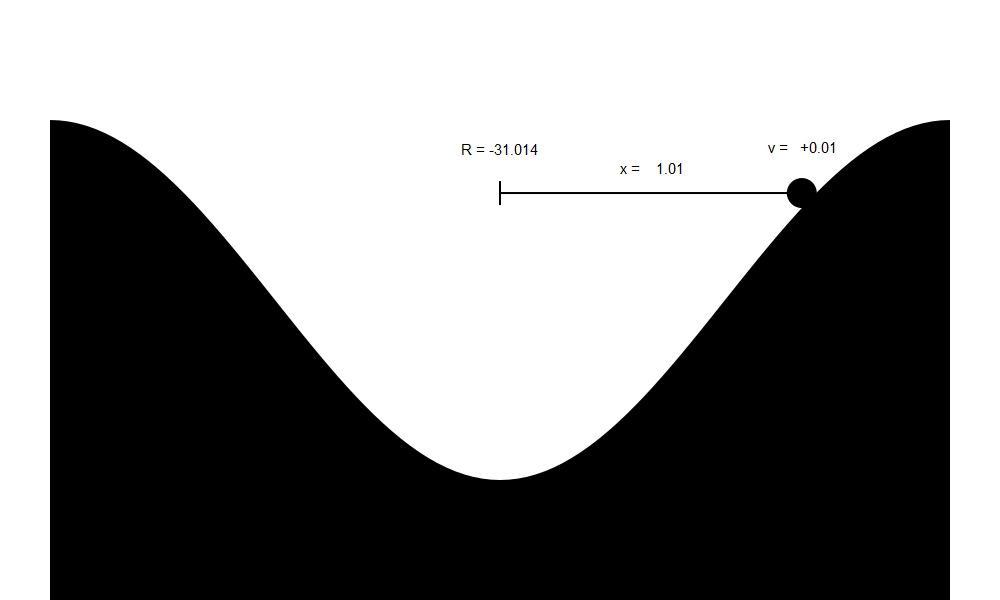
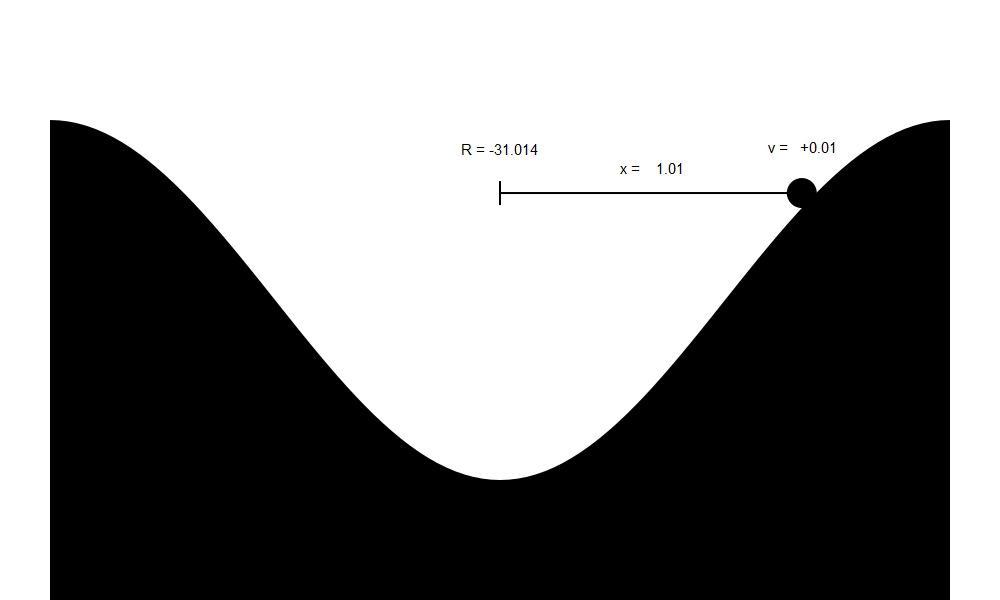

In [14]:
function animate(steps)
    car = MountainCar(0.0,0.0)
    frames = []
    R = 0
    for t = 1:steps
        a = car.v > 0.0 ? :right : :left
        car = update!(car, a)
        R = R*0.99 + reward(car, a)
        push!(frames, render_mountain_car(car, render_pos_overlay=true, reward=R))
    end
    frames
end

animation = animate(200)
@manipulate for i = 1:length(animation)
    animation[i]
end